In [1]:
import numpy
from matplotlib import pyplot, animation
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
%matplotlib inline
from scipy import linalg

In [2]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
def lhs_operator(M, N, sigma):
    """
    Assembles and returns the implicit operator
    of the system for the 2D diffusion equation.
    We use a Dirichlet condition at the left and
    bottom boundaries and a Neumann condition
    (zero-gradient) at the right and top boundaries.
    
    Parameters
    ----------
    M : integer
        Number of interior points in the x direction.
    N : integer
        Number of interior points in the y direction.
    sigma : float
        Value of alpha * dt / dx**2.
    
    Returns
    -------
    A : numpy.ndarray
        The implicit operator as a 2D array of floats
        of size M*N by M*N.
    """
    A = numpy.zeros((M * N, M * N))
    for j in range(N):
        for i in range(M):
            I = j * M + i  # row index
            # Get index of south, west, east, and north points.
            south, west, east, north = I - M, I - 1, I + 1, I + M
            # Setup coefficients at corner points.
            if i == 0 and j == 0:  # bottom-left corner
                A[I, I] = 1.0 / sigma + 4.0
                A[I, east] = -1.0
                A[I, north] = -1.0
            elif i == M - 1 and j == 0:  # bottom-right corner
                A[I, I] = 1.0 / sigma + 3.0
                A[I, west] = -1.0
                A[I, north] = -1.0
            elif i == 0 and j == N - 1:  # top-left corner
                A[I, I] = 1.0 / sigma + 3.0
                A[I, south] = -1.0
                A[I, east] = -1.0
            elif i == M - 1 and j == N - 1:  # top-right corner
                A[I, I] = 1.0 / sigma + 2.0
                A[I, south] = -1.0
                A[I, west] = -1.0
            # Setup coefficients at side points (excluding corners).
            elif i == 0:  # left side
                A[I, I] = 1.0 / sigma + 4.0
                A[I, south] = -1.0
                A[I, east] = -1.0
                A[I, north] = -1.0
            elif i == M - 1:  # right side
                A[I, I] = 1.0 / sigma + 3.0
                A[I, south] = -1.0
                A[I, west] = -1.0
                A[I, north] = -1.0
            elif j == 0:  # bottom side
                A[I, I] = 1.0 / sigma + 4.0
                A[I, west] = -1.0
                A[I, east] = -1.0
                A[I, north] = -1.0
            elif j == N - 1:  # top side
                A[I, I] = 1.0 / sigma + 3.0
                A[I, south] = -1.0
                A[I, west] = -1.0
                A[I, east] = -1.0
            # Setup coefficients at interior points.
            else:
                A[I, I] = 1.0 / sigma + 4.0
                A[I, south] = -1.0
                A[I, west] = -1.0
                A[I, east] = -1.0
                A[I, north] = -1.0
    return A

In [4]:
def rhs_vector(T, M, N, sigma, Tb, dx, dy, qx, qy):
    """
    Assembles and returns the right-hand side vector
    of the system for the 2D diffusion equation.
    We use a Dirichlet condition at the left and
    bottom boundaries and a Neumann condition
    (zero-gradient) at the right and top boundaries.
    
    Parameters
    ----------
    T : numpy.ndarray
        The temperature distribution as a 1D array of floats.
    M : integer
        Number of interior points in the x direction.
    N : integer
        Number of interior points in the y direction.
    sigma : float
        Value of alpha * dt / dx**2.
    Tb : float
        Boundary value for Dirichlet conditions.
    
    Returns
    -------
    b : numpy.ndarray
        The right-hand side vector as a 1D array of floats
        of size M*N.
    """
    b = 1.0 / sigma * T
    # Add Dirichlet term at points located next
    # to the left and bottom boundaries.
    for j in range(N):
        for i in range(M):
            I = j * M + i
            if i == 0:
                b[I] += Tb
            if j == 0:
                b[I] += Tb
            elif i == M:
                b[I] += dx*qx
            elif j == N:
                b[I] += dy*qy
    return b

In [5]:
def map_1d_to_2d(T_1d, nx, ny, Tb):
    """
    Maps a 1D array of the temperature at the interior points
    to a 2D array that includes the boundary values.
    
    Parameters
    ----------
    T_1d : numpy.ndarray
        The temperature at the interior points as a 1D array of floats.
    nx : integer
        Number of points in the x direction of the domain.
    ny : integer
        Number of points in the y direction of the domain.
    Tb : float
        Boundary value for Dirichlet conditions.
    
    Returns
    -------
    T : numpy.ndarray
        The temperature distribution in the domain
        as a 2D array of size ny by nx.
    """
    T = numpy.zeros((ny, nx))
    # Get the value at interior points.
    T[1:-1, 1:-1] = T_1d.reshape((ny - 2, nx - 2))
    # Use Dirichlet condition at left and bottom boundaries.
    T[:, 0] = Tb
    T[0, :] = Tb
    # Use Neumann condition at right and top boundaries.
    T[:, -1] = T[:, -2]
    T[-1, :] = T[-2, :]
    return T

In [6]:
def btcs_implicit_2d(T0, nt, dt, dx, dy, alpha, Tb, qx, qy):
    """
    Computes and returns the distribution of the
    temperature after a given number of time steps.
    
    The 2D diffusion equation is integrated using
    Euler implicit in time and central differencing
    in space, with a Dirichlet condition at the left
    and bottom boundaries and a Neumann condition
    (zero-gradient) at the right and top boundaries.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        The initial temperature distribution as a 2D array of floats.
    nt : integer
        Number of time steps to compute.
    dt : float
        Time-step size.
    dx : float
        Grid spacing in the x and y directions.
    alpha : float
        Thermal diffusivity of the plate.
    Tb : float
        Boundary value for Dirichlet conditions.
    
    Returns
    -------
    T : numpy.ndarray
        The temperature distribution as a 2D array of floats.
    """
    # Get the number of points in each direction.
    ny, nx = T0.shape
    # Get the number of interior points in each direction.
    M, N = nx - 2, ny - 2
    # Compute the constant sigma.
    sigma = alpha * dt / dx**2
    # Create the implicit operator of the system.
    A = lhs_operator(M, N, sigma)
    # Integrate in time.
    T_hist = []
    T = T0[1:-1, 1:-1].flatten() # interior points as a 1D array
    T_hist = [T0.copy()]
    T_centre_hist = [20]
    I, J = int(M / 2), int(N / 2)  # indices of the center
    for n in range(nt):
        # Compute the right-hand side of the system.
        b = rhs_vector(T, M, N, sigma, Tb, dx, dy, qx, qy)
        # Solve the system with scipy.linalg.solve.
        T = linalg.solve(A, b)
        T_dist = map_1d_to_2d(T, nx, ny, Tb) #convert temperautre values in 2D array like the physical space
        T_hist.append(T_dist)
        T_centre_hist.append(T[J*M + I])
        # Check if the center of the domain has reached T = 70C.
        #if T[J * M + I] >= 70.0:
            #break
    #print('[time step {}] Center at T={:.2f} at t={:.2f} s'
          #.format(n + 1, T[J * M + I], (n + 1) * dt))
    # Returns the temperature in the domain as a 2D array.
    #return map_1d_to_2d(T, nx, ny, Tb)
        
    return T_hist, T_centre_hist
        

In [7]:
# Set parameters.
Lx = 0.01  # length of the plate in the x direction
Ly = 0.01  # height of the plate in the y direction
nx = 21  # number of points in the x direction
ny = 21  # number of points in the y direction
dx = Lx / (nx - 1)  # grid spacing in the x direction
dy = Ly / (ny - 1) # grid spacing in the y direction
qx, qy = -1e+10, -100000.0
alpha = 1e-4  # thermal diffusivity of the plate

# Define the locations along a gridline.
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

# Compute the initial temperature distribution.
Tb = 100.0  # temperature at the left and bottom boundaries
T0 = 20.0 * numpy.ones((ny, nx))
T0[0, :] = Tb
T0[:, 0] = Tb

In [8]:
# Set the time-step size based on CFL limit.
sigma = 1
dt = sigma * min(dx, dy)**2 / alpha  # time-step size
nt = 300 # number of time steps to compute

# Compute the temperature along the rod.
T = btcs_implicit_2d(T0, nt, dt, dx, dy, alpha, Tb, qx, qy)[1]
T_hist = btcs_implicit_2d(T0, nt, dt, dx, dy, alpha, Tb, qx, qy)[0]


In [9]:
print(len(T), len(T_hist), T_hist[0].shape)

301 301 (21, 21)


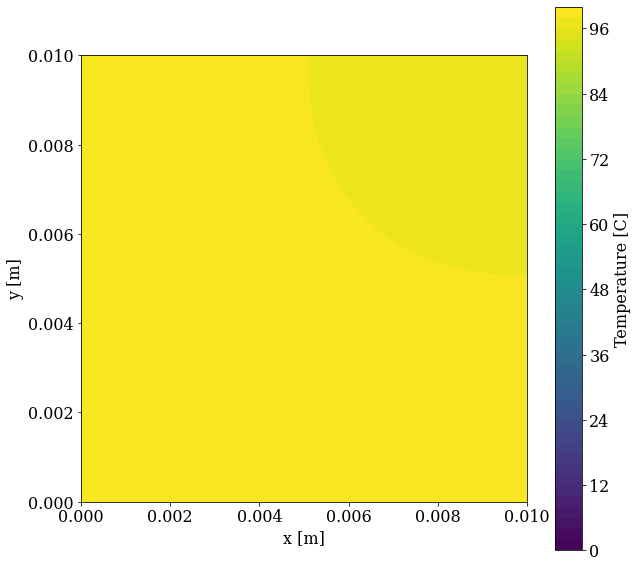

In [10]:
fig2 = pyplot.figure(figsize=(10.0, 10.0))
ims2 = []

pyplot.xlabel('x [m]')
pyplot.ylabel('y [m]')
levels = numpy.linspace(0.0, 100.0, num=51)
for i in range(nt):
    contf = pyplot.contourf(x,y,T_hist[i], levels = levels)
    #pyplot.title('t = %i:  %.2f' % (i, i*dt))
    #fig.suptitle('Time step {:0>5}'.format(i))
    #fig.suptitle('Temp centre {:0>}'.format(T_centre_hist[i]))
    ims2.append(contf.collections)
cbar = pyplot.colorbar(contf)
cbar.set_label('Temperature [C]')
pyplot.axis('scaled');

In [11]:
ani2 = ArtistAnimation(fig2, ims2, interval = 50, repeat = True)
HTML(ani2.to_html5_video())

In [12]:
t = numpy.arange(0, nt+1, 1)

(0.0, 100.0)

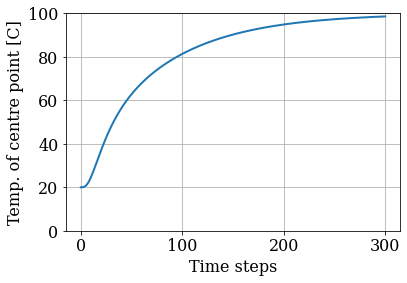

In [13]:
#variation of temp of centre point with time steps. 
fig = pyplot.figure(figsize = (6.0, 4.0))
pyplot.xlabel('Time steps')
pyplot.ylabel('Temp. of centre point [C]')
pyplot.grid()
line = pyplot.plot(t, T, color = 'C0', linestyle = '-', linewidth = 2)
#pyplot.xlim(0.0, 300)
pyplot.ylim(0.0, 100.0)